In [1]:
from u_net import *
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda,MaxPooling2D,Dropout,Conv2DTranspose,concatenate

2.0.0-alpha0


In [2]:
#from tf.keras import backend as K
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
random.seed = 40
np.random.seed = 40

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:54<00:00,  9.63it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 136.33it/s]

Done!


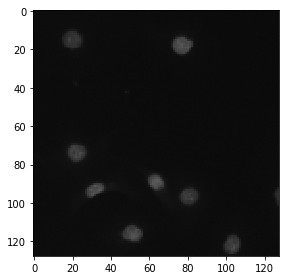

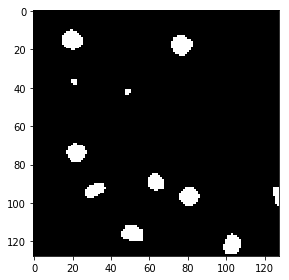

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
#eval metrics
# def mean_iou(y_true, y_pred):
#     return tf.metrics.mean_iou(
#     y_true,
#     y_pred,
#     num_classes,
#     weights=None,
#     metrics_collections=None,
#     updates_collections=None,
#     name=None
#     )
    

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, dtype=tf.int32)
        m = tf.keras.metrics.MeanIoU(num_classes=2)
        score, up_opt=m.update_state(y_true, y_pred)
#         score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2,y_pred)
#         tf.compat.v1.get_session_handle().run(tf.compat.v1.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
               score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [ ]:
input_dimension=(128,128,3)
lr=0.001

inputs = Input(input_dimension)
s = Lambda(lambda x: x ) (inputs)
inblock_inp= inblock(s)
resblock_a1=resblock_A(inblock_inp,32)
path1=Path_1(resblock_a1)
    
    #reduction_a=reduction_A(resblock_a1)
reduction_a=tf.keras.layers.MaxPooling2D((2,2))(resblock_a1)
resblock_a2=resblock_A(reduction_a,64)
path2=Path_2(resblock_a2)
    
reduction_b=tf.keras.layers.MaxPooling2D((2,2))(resblock_a2
                                                         )
resblock_b1=resblock_B(reduction_b)
path3=Path_3(resblock_b1)
    
Mpooling=tf.keras.layers.MaxPooling2D((2,2))(resblock_b1)
resblock_b2=resblock_B(Mpooling)
path4=Path_4(resblock_b2)
    
Mpooling2=tf.keras.layers.MaxPooling2D((2,2))(resblock_b2)
resblock_c=resblock_C(Mpooling2)
    
Up1=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(resblock_c),path4],axis=3)
resblock_b2=resblock_B(Up1)

Up2=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(resblock_b2),path3],axis=3)
resblock_b3=resblock_B(Up2)

    
Up3=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(resblock_b3),path2],axis=3)
resblock_a3=resblock_A(Up3,64)
    
    
    
Up4=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(resblock_a3),path1],axis=3)
resblock_a4=resblock_A(Up4,32)

outblock=inblock(resblock_a4)
print("out",outblock.shape)    
conv_final=Conv2D(1,(1,1),activation='sigmoid',padding='same')(outblock)
print("conv final",conv_final.shape)   


model = tf.keras.Model(inputs=[inputs], outputs=[conv_final])
#model.compile(tf.optimizers.Adam(lr),loss = 'binary_crossentropy', metrics = ['accuracy'])

model = tf.keras.utils.multi_gpu_model(model,gpus=2, cpu_merge=False)
#print("Training using multiple GPUs..")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
print(model.summary())


In [ ]:
inputs = Input((128, 128,3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

In [ ]:
# Fit model
#model.compile(tf.optimizers.Adam(learning_rate=0.001),loss = 'binary_crossentropy', metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='min', verbose=1)
cs = tf.keras.callbacks.ModelCheckpoint('test_1.h5',monitor='val_accuracy', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,shuffle=True,steps_per_epoch=None,callbacks=[es,cs])

In [ ]:
# Fit model
#model.compile(tf.optimizers.Adam(learning_rate=0.001),loss = 'binary_crossentropy', metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='min', verbose=1)
cs = tf.keras.callbacks.ModelCheckpoint('test_2.h5',monitor='val_accuracy', verbose=1, save_best_only=True)
results = model1.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,shuffle=True,steps_per_epoch=None,callbacks=[es,cs])

In [ ]:
# Predict on train, val and test
#model = load_model('test_1.h5', custom_objects={'mean_iou': my_iou_metric})
#tf.keras.models.save_model(model, "./model/test_1.h5",)
model = tf.keras.models.load_model('test_1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Predict on train, val and test
#model = load_model('test_1.h5', custom_objects={'mean_iou': my_iou_metric})
#tf.keras.models.save_model(model, "./model/test_1.h5",)
model = tf.keras.models.load_model('test_2.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()